## Training Materials Outline: ALOS-2 Data Preprocessing
**Module 1: Introduction to ALOS-2 Data and Applications**

* 1.1 What is ALOS-2?
    * Overview of the ALOS-2 satellite and its sensors (PALSAR-2).
    * Key features and advantages of ALOS-2 data.
* 1.2 Applications of ALOS-2 Data
    * Focus on forest monitoring, deforestation detection, and oil palm plantation mapping.
    * Examples of real-world applications.
* 1.3 Data Access and Formats
    * Sources for downloading ALOS-2 data (JAXA, ASF DAAC).
    * Explanation of common data formats (GeoTIFF, HDF5).

**Module 2: ALOS-2 Data Preprocessing**

* 2.1 Loading ALOS-2 Data with `rasterio`
    * Opening GeoTIFF files.
    * Reading image data into `numpy` arrays.
    * Accessing metadata (e.g., transform, CRS).
* 2.2 Speckle Filtering with the Lee Filter
    * Implementing the Lee filter function in Python.
    * Applying the filter to the original image.
    * Visualizing the effects of filtering.
* 2.3 Radiometric Calibration
    * Applying the calibration formula: `(10 * np.log10(filtered_image**2)) - 83`.
    * Explanation of the calibration process and its importance.
* 2.4 Saving Preprocessed Data
    * Writing processed data to new GeoTIFF files using `rasterio`.
    * Updating metadata to reflect changes (e.g., data type).

In [1]:
!pip install rasterio numpy geopandas matplotlib scipy scikit-image

In [18]:
import numpy as np
import rasterio
from skimage import img_as_float
from scipy.ndimage import uniform_filter
import matplotlib.pyplot as plt

In [19]:
# Define the Lee filter function
def lee_filter(image, size):
    """
    Applies the Lee filter to reduce speckle noise.
    """
    image = image.astype(np.float32)
    local_mean = uniform_filter(image, size=size)
    local_mean_sqr = uniform_filter(image**2, size=size)
    local_variance = local_mean_sqr - local_mean**2
    overall_variance = np.mean(local_variance)
    weight = local_variance / (local_variance + overall_variance)
    weight = np.clip(weight, 0, 1)
    filtered_image = local_mean + weight * (image - local_mean)
    return filtered_image

In [20]:
# Define the calibration function
def calibrate_image(image):
    """
    Converts the image to backscatter coefficients.
    """
    image = img_as_float(image)
    calibrated_image = (10 * np.log10(image**2)) - 83
    return calibrated_image

In [21]:
# Specify the image path (replace with your specific image path)
image_path = "/home/jovyan/shared/Arissara/genAI/Yamba/IMG-HH-ALOS2294160720-191103-UBSR2.1GUA.tif"

In [22]:
# Load the image
with rasterio.open(image_path) as src:
    original_image = src.read(1)  # Read the first band
    profile = src.profile  # Get the metadata profile

In [23]:
# Step 1: Apply Lee filter
filtered_image = lee_filter(original_image, size=5)

In [24]:
# Step 2: Apply calibration
calibrated_image = calibrate_image(filtered_image)

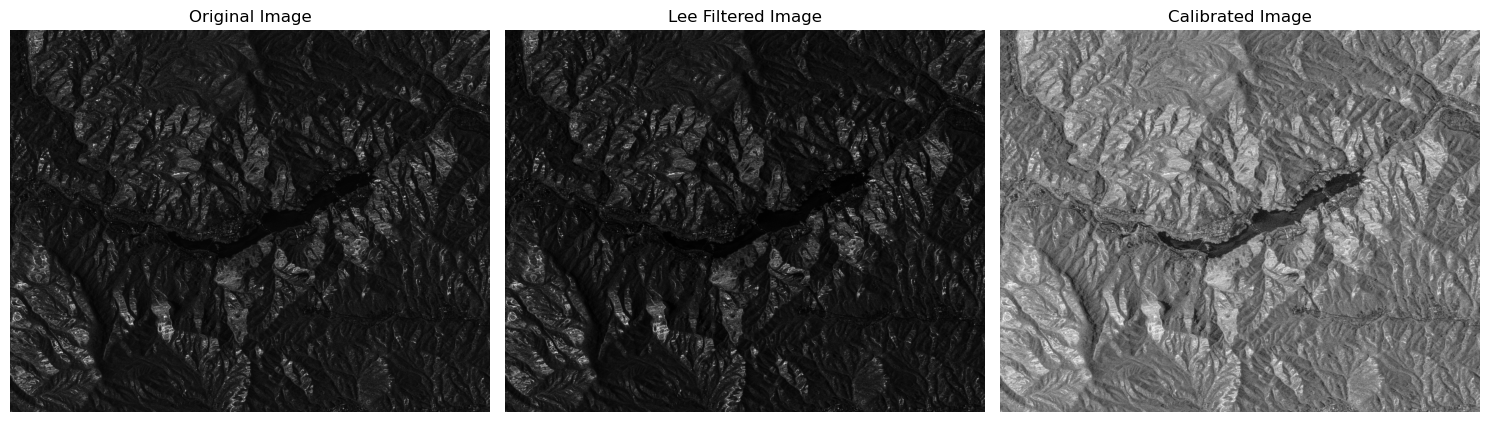

In [25]:
# Step 3: Visualize the original and processed images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis("off")

# Filtered image
axes[1].imshow(filtered_image, cmap='gray')
axes[1].set_title("Lee Filtered Image")
axes[1].axis("off")

# Calibrated image
axes[2].imshow(calibrated_image, cmap='gray')
axes[2].set_title("Calibrated Image")
axes[2].axis("off")

plt.tight_layout()
plt.show()


In [26]:
# Specify output folder (make sure it exists or create it)
output_folder = "/home/jovyan/shared/Arissara/genAI"
os.makedirs(output_folder, exist_ok=True)

# Save the calibrated image
calibrated_image_path = os.path.join(output_folder, "calibrated_image.tif")
with rasterio.open(calibrated_image_path, 'w', **profile) as dst:
    dst.write(calibrated_image.astype(np.float32), 1)